In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import normalized_mutual_info_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tqdm import tqdm
import time


# Data

### preprocces method


In [2]:
def process_data(file_path, per_cluster=None):
    # Read the data
    data = pd.read_csv(file_path, header=None)
    
    if per_cluster:
        # Filter the data to keep only the specified number of entries per cluster
        filtered_data = data.groupby(0).apply(lambda x: x.head(per_cluster)).reset_index(drop=True)
    else:
        # If per_cluster is not specified, use all the data
        filtered_data = data
    
    # Extract feature columns and true labels
    X = filtered_data.iloc[:, 3:].values  # Feature columns
    true_labels = filtered_data.iloc[:, 0].values  # True labels (BLOCK ID)
    
    # Normalize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    return X_scaled, true_labels

In [11]:
X_scaled, true_labels = process_data('bio_train.csv')

# Clustring routine

In [4]:
def perform_clustering(X, k, max_iters, num_loops, clustering_function, **kwargs):
    all_labels = []
    all_centroids = []
    all_nmi_scores = []
    all_runtimes = []
    all_distance_calculations = []
    all_inertia_histories = []
    all_num_iterations = []

    for i in range(num_loops):
        # Ensure max_iters is passed correctly as a keyword argument
        centroids, labels, num_iterations, inertia_history, distance_calculations, runtime = clustering_function(
            X, k, max_iters, **kwargs
        )
        nmi_score = normalized_mutual_info_score(true_labels, labels, average_method='arithmetic')
        
        # Append results to lists
        all_num_iterations.append(num_iterations)
        all_labels.append(labels)
        all_centroids.append(centroids)
        all_nmi_scores.append(nmi_score)
        all_runtimes.append(runtime)
        all_distance_calculations.append(distance_calculations)
        all_inertia_histories.append(inertia_history)

    return {
        'centroids': all_centroids,
        'labels': all_labels,
        'num_iterations': all_num_iterations,
        'inertia_histories': all_inertia_histories,
        'distance_calculations': all_distance_calculations,
        'runtimes': all_runtimes,
        'nmi_scores': all_nmi_scores
    }


# Visualization

In [16]:
def visualize_clustering_results(results):
    # Extract the results
    all_inertia_histories = results['inertia_histories']
    all_nmi_scores = results['nmi_scores']
    all_runtimes = results['runtimes']
    all_distance_calculations = results['distance_calculations']
    
    # Define a list of colors for the bars
    colors = ['blue', 'orange', 'green', 'red', 'purple', 'grey']
    
    def plot_line(data, title, xlabel, ylabel, yscale='linear'):
        plt.figure(figsize=(10, 8))
        if isinstance(data[0], list):
            for i, history in enumerate(data):
                plt.plot(history, label=f'Run {i+1}')
            plt.legend()
        else:
            plt.plot(data, label='Run 1')
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.yscale(yscale)
        plt.grid(True)
        plt.show()

    def plot_bar(data, avg, title, xlabel, ylabel):
        plt.figure(figsize=(10, 6))
        if isinstance(data, list):
            bar_data = data + [avg]
            xticks_labels = [f'Run {i}' for i in range(1, len(data)+1)] + ['Average']
        else:
            bar_data = [data, avg]
            xticks_labels = ['Run 1', 'Average']
        
        plt.bar(range(1, len(bar_data) + 1), bar_data, color=colors[:len(bar_data)], alpha=0.7)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(title)
        plt.xticks(range(1, len(bar_data) + 1), labels=xticks_labels)
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.show()
    
    # Plot the inertia histories
    plot_line(all_inertia_histories, 'K-means Convergence', 'Iteration', 'Inertia', yscale='log')
    
    # Plot the runtimes
    average_runtime = np.mean(all_runtimes) if isinstance(all_runtimes, list) else all_runtimes
    plot_bar(all_runtimes, average_runtime, 'Runtimes for Each Run and Average Runtime', 'Run Number', 'Runtime (seconds)')
    
    # Plot the distance calculations
    average_distance_calculations = np.mean(all_distance_calculations) if isinstance(all_distance_calculations, list) else all_distance_calculations
    plot_bar(all_distance_calculations, average_distance_calculations, 'Distance Calculations for Each Run and Average', 'Run Number', 'Number of Distance Calculations')
    
    # Calculate and print average NMI score
    average_nmi = np.mean(all_nmi_scores) if isinstance(all_nmi_scores, list) else all_nmi_scores
    print(f"Average NMI Score: {average_nmi:.4f}")

#  Lloyd’s algorithm for k-Means Clustering 

In [13]:
# Custom K-means and related functions
def initialize_centroids(X, k):
    """Randomly initialize centroids from the data points X."""
    indices = np.random.permutation(X.shape[0])[:k]
    return X[indices]

def assign_clusters(X, centroids):
    """Assign data points to the nearest centroid using batch processing."""
    n_samples = X.shape[0]
    batch_size = 100  # Adjust batch size based on available memory
    labels = np.empty(n_samples, dtype=int)
    
    for start_idx in range(0, n_samples, batch_size):
        end_idx = min(start_idx + batch_size, n_samples)
        distances = np.sqrt(((X[start_idx:end_idx] - centroids[:, np.newaxis])**2).sum(axis=2))
        labels[start_idx:end_idx] = np.argmin(distances, axis=0)
    
    return labels


def update_centroids(X, labels, k):
    """Update centroids as the mean of assigned data points."""
    new_centroids = np.empty((k, X.shape[1]))
    for i in range(k):
        cluster_points = X[labels == i]
        if len(cluster_points) > 0:
            new_centroids[i] = cluster_points.mean(axis=0)
        else:
            # If cluster has no assigned points, randomly reinitialize the centroid
            new_centroids[i] = X[np.random.choice(X.shape[0])]
    return new_centroids


def kmeans(X, k, max_iters=5000):
    centroids = initialize_centroids(X, k)
    inertia_history = []
    total_distance_calculations = 0
    start_time = time.time()  # Start timing

    for i in tqdm(range(max_iters), desc="K-means Iteration"):
        labels = assign_clusters(X, centroids)
        new_centroids = update_centroids(X, labels, k)
        inertia = np.sum((X - centroids[labels])**2)
        inertia_history.append(inertia)
        total_distance_calculations += X.shape[0] * k  # Each assign_clusters call
        if np.all(centroids == new_centroids):
            break
        centroids = new_centroids

    runtime = time.time() - start_time  # End timing
    return centroids, labels, i + 1, inertia_history, total_distance_calculations, runtime

In [14]:
results_k_means = perform_clustering(X_scaled, 153, 20, 1, kmeans)

K-means Iteration: 100%|██████████| 20/20 [03:09<00:00,  9.47s/it]


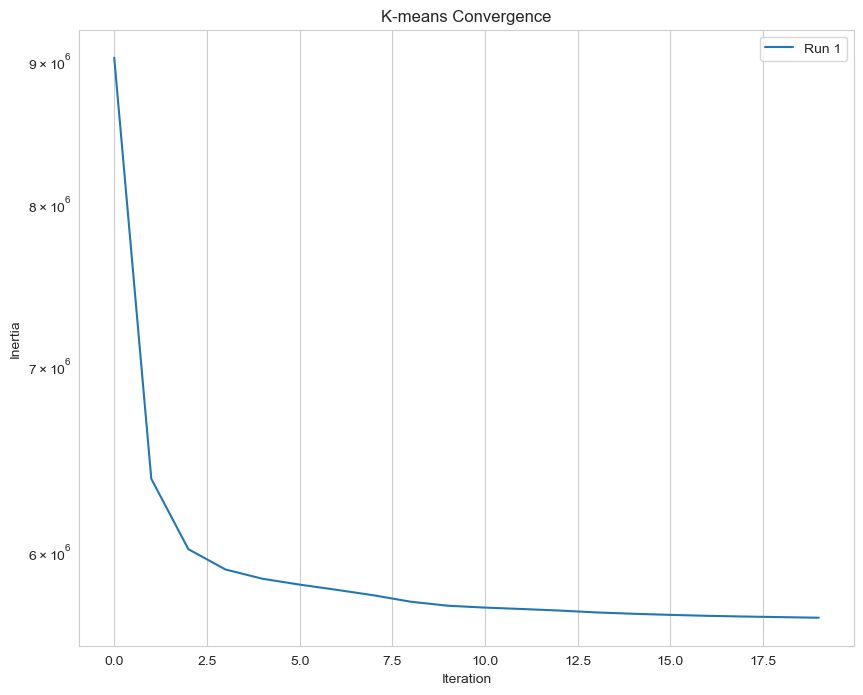

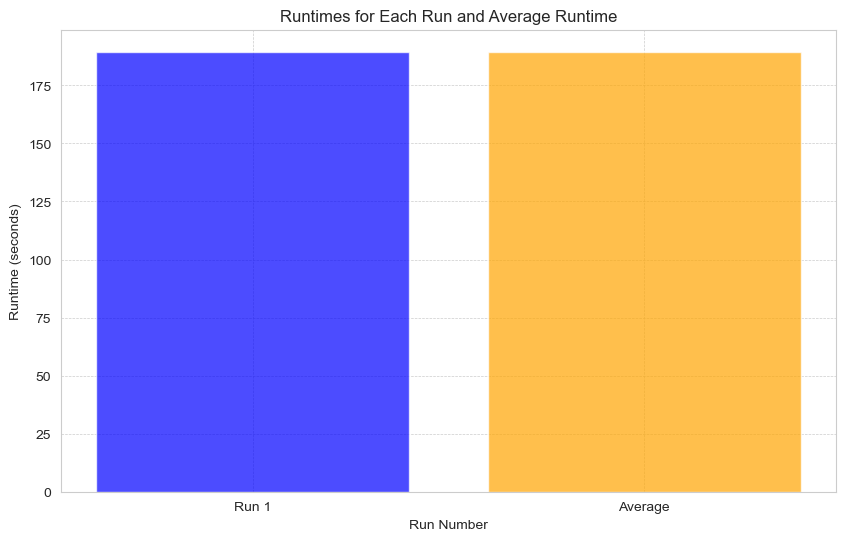

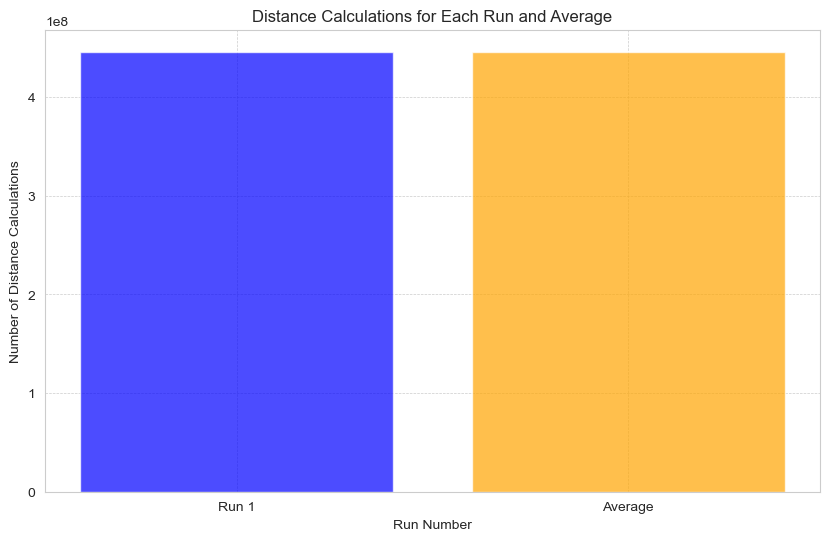

Average NMI Score: 0.1864


In [17]:
visualize_clustering_results(results_k_means)

# k-Means with Locality Sensitive Hashing (LSH)

We have implemented the lsh_has_function as given in the assignement.   
The hash function $h_{a,b}(p): \mathbb{R}^d \rightarrow \mathbb{N}$ maps a point $p \in \mathbb{R}^d$ to a natural number, defined as:   
$ h_{a,b}(p) = \left\lfloor \frac{{\mathbf{a \cdot p} + b}}{{w}} \right\rfloor $

Where:
- $a$ is a random vector in $\mathbb{R}^d$,
- $b$ is a scalar parameter in the range $[0, w]$,
- $w$ is a scalar parameter determining the width of the hash bins,
- $\mathbf{a \cdot p}$ denotes the dot product between vectors $a$ and $p$.

This is done in lsh_hash_function, so first we initialize the lsh with initialize_lsh, where we create a number of a and b vectors according to the number of hash funcs we want. Then we compute the hash signitatur for every point with compute_lsh_hashes

In [27]:
# Define the LSH hash function as a standalone function
def lsh_hash_function(X, a, b, w):
    """
    Computes the hash values for a dataset X using a single hash function.
    
    Parameters:
    X (numpy array): The dataset with shape (n, d), where n is the number of data points and d is the dimensionality.
    a (numpy array): A random vector for projection with shape (d,).
    b (float): A random offset.
    w (float): The bin width.
    
    Returns:
    numpy array: An array of hash values with shape (n,).
    """
    projection = X.dot(a)  # Project points onto vector a
    shifted_projection = projection + b  # Shift by offset b
    normalized_value = shifted_projection / w  # Normalize by bin width w
    bin_index = np.floor(normalized_value)  # Get bin index by flooring
    return bin_index

# Initialize LSH parameters and create a list of hash functions
def initialize_lsh(X, n, m, w):
    """
    Initializes parameters for LSH hash functions for a dataset.
    
    Parameters:
    X (numpy array): The dataset with shape (n, d), where n is the number of data points and d is the dimensionality.
    n (int): The number of groups of hash functions.
    m (int): The number of hash functions in each group.
    w (float): The bin width.
    
    Returns:
    tuple: A tuple containing the list of random vectors (a) and the list of random offsets (b).
    """
    
    # Get the number of data points (n) and the dimensionality (d)
    num_data_points, d = X.shape
    
    # Generate random vectors for projection, one for each hash function
    a = np.random.randn(n * m, d)
    
    # Generate random offsets for each hash function
    b = np.random.uniform(0, w, n * m)
    
    return a, b, w

# Compute hash values for all data points
def compute_lsh_hashes(X, a, b, w):
    """
    Computes the hash values for all data points in a dataset using a list of hash functions.
    
    Parameters:
    X (numpy array): The dataset with shape (n, d), where n is the number of data points and d is the dimensionality.
    a (numpy array): A list of random vectors for projection with shape (num_hashes, d).
    b (numpy array): A list of random offsets with shape (num_hashes,).
    w (float): The bin width.
    
    Returns:
    numpy array: An array of hash values with shape (n, num_hashes).
    """
    num_hashes = len(a)
    hashes = np.column_stack([lsh_hash_function(X, a[i], b[i], w) for i in range(num_hashes)])
    return hashes  # Convert list to numpy array


For the k- means our two most important algorithms are First, the number of data points in X is determined and stored in n_samples. An array labels is initialized to store the cluster assignment for each data point. The hash values for each centroid are computed and stored in centroid_hashes. An empty list hash_groups is initialized to store groups of hash functions, and a list bucket_random_points is initialized to store random points from each bucket (cluster).

Next, a loop runs n times to create n groups of m hash functions. For each group, the start and end indices for the current group of hash functions are determined, and the group of m hash functions is added to hash_groups.

Then, the function iterates over each point i in X. For each point, potential_centroids is initialized to track centroids that match the hash values. The function then checks each group of hash functions to see if all hashes in the group match between the point and the centroids. If a match is found, potential_centroids is updated with the matching results.

If any potential centroid matches are found, the distances from the point to all potential centroids are computed, and the point is assigned to the closest centroid. If no matches are found, a random point is selected, distances to all centroids are computed, and the point is assigned to the closest centroid. The point is then stored in bucket_random_points for its assigned centroid.

Finally, the function returns labels (cluster assignments) and bucket_random_points (random points from each bucket).

In [32]:
# Custom K-means functions
def initialize_centroids(X, k):
    indices = np.random.permutation(X.shape[0])[:k]
    return X[indices]

def assign_clusters_lsh(X, centroids, hashes, a, b, w, n=4, m=4):
    n_samples = X.shape[0]
    labels = np.empty(n_samples, dtype=int)
    
    # Compute centroid hashes
    centroid_hashes = compute_lsh_hashes(centroids, a, b, w)
    
    # Initialize an empty list to store the groups of hash functions
    hash_groups = []
    
    # Initialize a list to store random points from each bucket
    bucket_random_points = [[] for _ in range(len(centroids))]
    
    # Loop over the range of n to create n groups
    for i in range(n):
        # Determine the start and end indices for the current group of m hash functions
        start_index = i * m
        end_index = min((i + 1) * m, len(a))  # Ensure we do not go out of bounds
        
        # Select the group of m hash functions from the list
        group = list(range(start_index, end_index))
        
        # Add the group to the list of hash groups
        hash_groups.append(group)
    
    for i, point_hash in enumerate(hashes):
        potential_centroids = np.zeros(len(centroids), dtype=bool)
        
        # Check each group for a match
        for group in hash_groups:
            # Get indices for the current group
            group_indices = group
            
            # Check if all hashes in the group match
            group_hashes = point_hash[group_indices]
            centroid_group_hashes = centroid_hashes[:, group_indices]
            group_matches = np.all(centroid_group_hashes == group_hashes, axis=1)
            
            # Update potential centroids with OR condition across groups
            potential_centroids = np.logical_or(potential_centroids, group_matches)
        
        # Determine the closest centroid
        if np.any(potential_centroids):
            distances = np.linalg.norm(X[i] - centroids[potential_centroids], axis=1)
            labels[i] = np.where(potential_centroids)[0][np.argmin(distances)]
        else:
            # If no match is found in any group, compute the similarity of a random point in the bucket to all centers
            random_point_index = np.random.randint(0, n_samples)
            distances = np.linalg.norm(X[random_point_index] - centroids, axis=1)
            closest_centroid = np.argmin(distances)
            
            # Assign all points in the bucket to the closest centroid
            labels[i] = closest_centroid
        
        # Store random points for each bucket
        bucket_random_points[labels[i]].append(X[i])
    
    return labels, bucket_random_points


def update_centroids(X, labels, k, bucket_random_points, num_random_points=1):
    """
    Update centroids using points from the assigned cluster and randomly selected points from other clusters.
    
    Parameters:
    X (numpy array): The dataset with shape (n, d), where n is the number of data points and d is the dimensionality.
    labels (numpy array): The current cluster assignment for each data point.
    k (int): The number of clusters.
    bucket_random_points (list of lists): List of random points from each bucket.
    num_random_points (int): Number of random points to include from other clusters for centroid update.
    
    Returns:
    numpy array: The updated centroids with shape (k, d).
    """
    new_centroids = np.empty((k, X.shape[1]))
    
    for i in range(k):
        # Points in the current cluster
        cluster_points = X[labels == i]
        
        # Collect random points from other clusters
        other_cluster_points = []
        for j in range(k):
            if j != i and len(bucket_random_points[j]) > 0:
                sampled_points = np.array(bucket_random_points[j])[np.random.choice(len(bucket_random_points[j]), num_random_points, replace=True)]
                other_cluster_points.append(sampled_points)
        
        # Concatenate the points from the cluster and the randomly selected points from other clusters
        if len(other_cluster_points) > 0:
            all_points = np.vstack([cluster_points] + other_cluster_points)
        else:
            all_points = cluster_points
        
        # Calculate the new centroid
        if len(all_points) > 0:
            new_centroids[i] = all_points.mean(axis=0)
        else:
            # If the cluster is empty, reinitialize the centroid randomly
            new_centroids[i] = X[np.random.choice(X.shape[0])]
    
    return new_centroids


def kmeans_lsh(X, k, max_iters=500, n=4, m=4, w=4.0, num_random_points=1):
    centroids = initialize_centroids(X, k)
    a, b, w = initialize_lsh(X, n, m, w)
    hashes = compute_lsh_hashes(X, a, b, w)
    
    inertia_history = []
    total_distance_calculations = 0
    start_time = time.time()

    for i in tqdm(range(max_iters), desc="K-means Iteration"):
        labels, bucket_random_points = assign_clusters_lsh(X, centroids, hashes, a, b, w, n, m)
        new_centroids = update_centroids(X, labels, k, bucket_random_points, num_random_points)
        inertia = np.sum((X - centroids[labels])**2)
        inertia_history.append(inertia)
        total_distance_calculations += X.shape[0] * k
        if np.all(centroids == new_centroids):
            break
        centroids = new_centroids

    runtime = time.time() - start_time
    return centroids, labels, i + 1, inertia_history, total_distance_calculations, runtime

In [31]:
results_k_means_lsh = perform_clustering(
    X_scaled, 
    153, 
    3, 
    1, 
    kmeans_lsh
)


K-means Iteration:   0%|          | 0/3 [00:00<?, ?it/s]C:\Users\Nenad\AppData\Local\Temp\ipykernel_13176\1963050968.py:16: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  group_matches = np.all(centroid_group_hashes[:, None, :] == group_hashes[:, None], axis=-1)
K-means Iteration:   0%|          | 0/3 [00:31<?, ?it/s]


MemoryError: Unable to allocate 12.3 GiB for an array with shape (145750, 153, 74) and data type float64

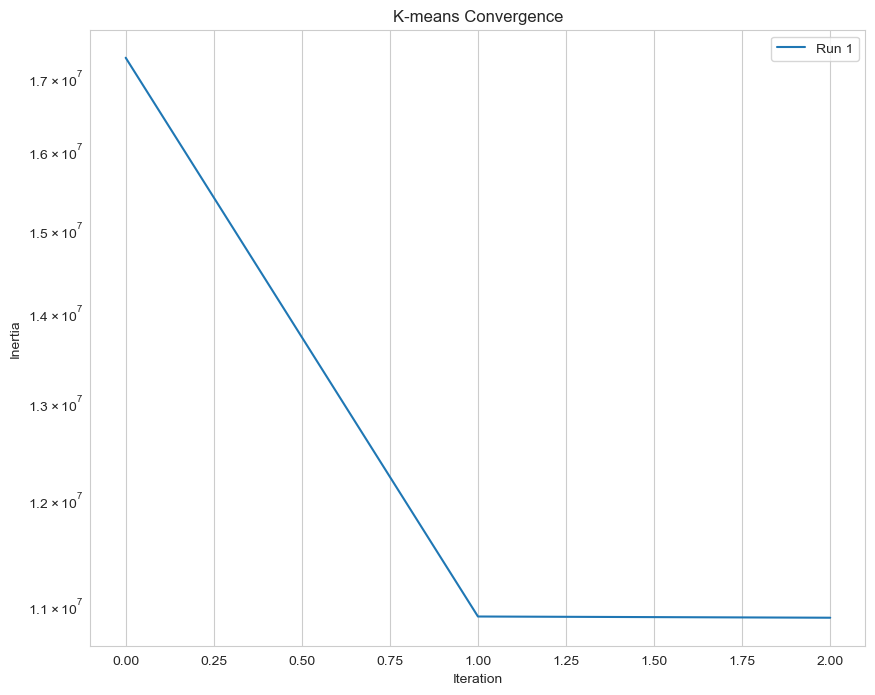

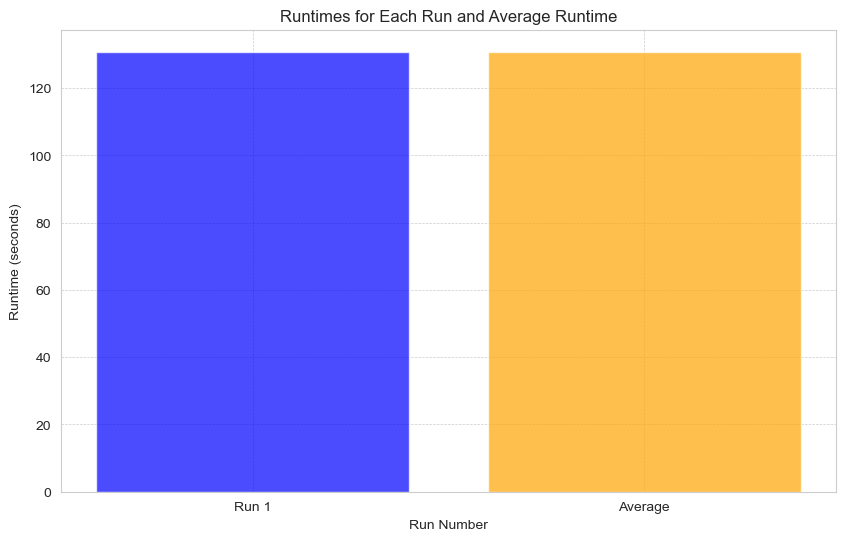

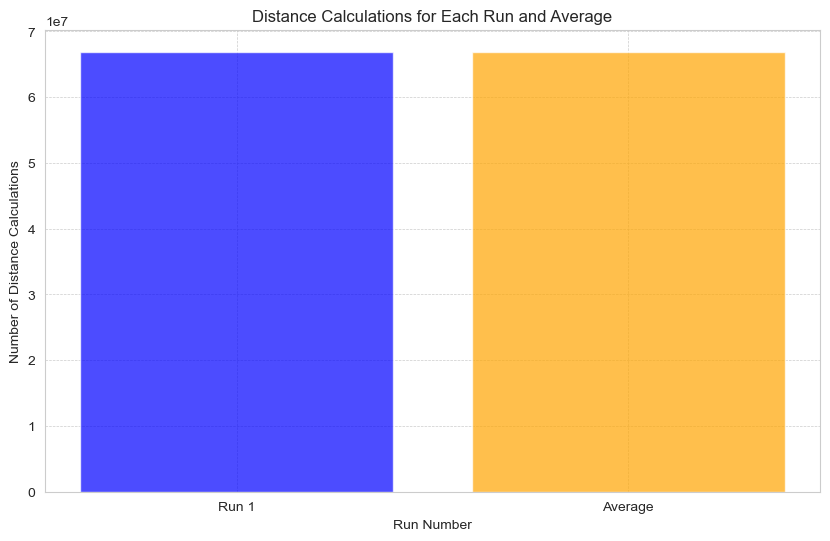

Average NMI Score: 0.0142


In [29]:
visualize_clustering_results(results_k_means_lsh)

K-means Iteration:  26%|██▌       | 13/50 [00:01<00:04,  7.40it/s]


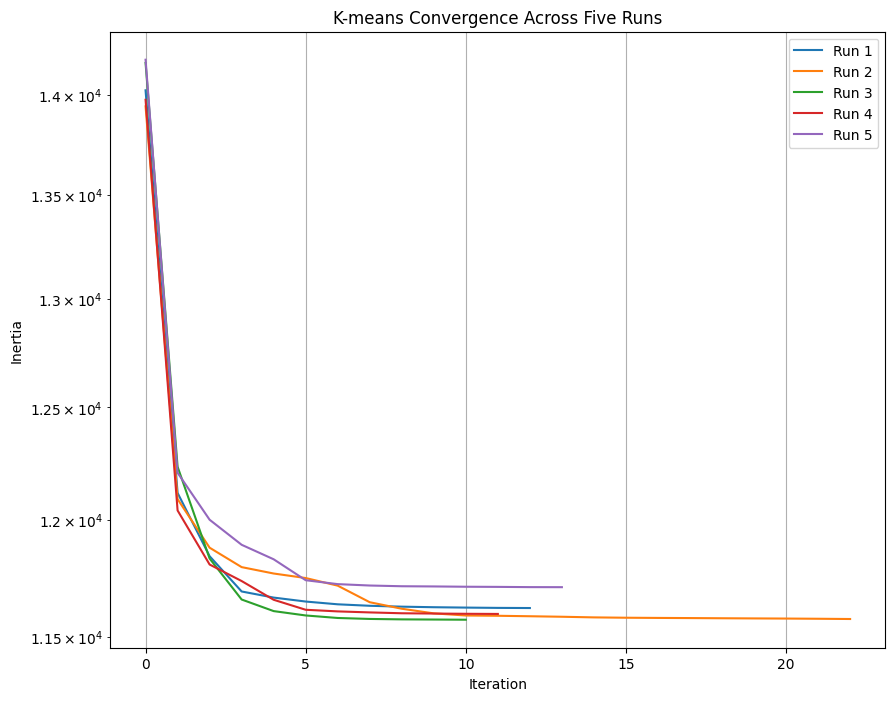

Average NMI Score over five runs: 0.3151


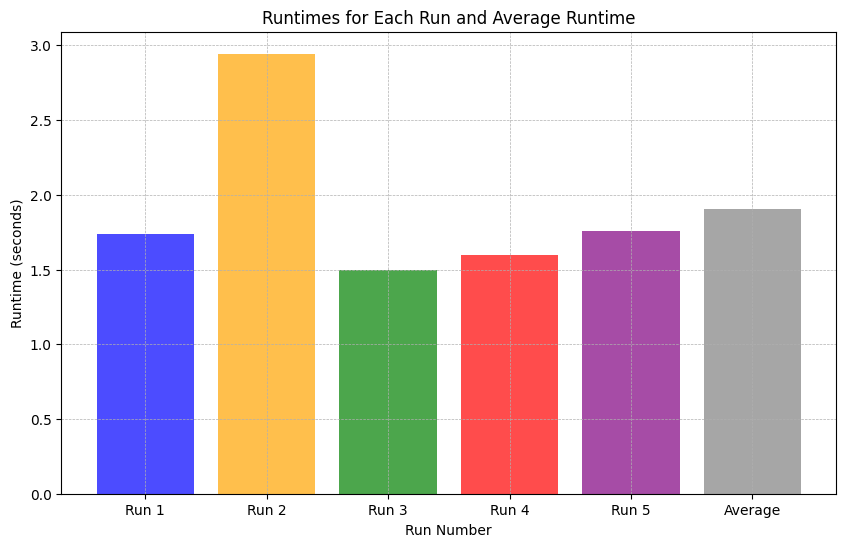

In [13]:
import numpy as np
from sklearn.metrics import normalized_mutual_info_score
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

def sample_coreset(X, k, m):
    # Simple random sampling for coreset
    indices = np.random.choice(X.shape[0], size=m, replace=False)
    return X[indices], np.ones(m) / m

def initialize_centroids(X, k):
    indices = np.random.permutation(X.shape[0])[:k]
    return X[indices]

def assign_clusters(X, centroids):
    distances = np.sqrt(((X[:, np.newaxis] - centroids) ** 2).sum(axis=2))
    labels = np.argmin(distances, axis=1)
    return labels, distances.min(axis=1).sum()

def update_centroids(X, labels, k, weights):
    centroids = np.zeros((k, X.shape[1]))
    for i in range(k):
        weighted_points = X[labels == i] * weights[labels == i, np.newaxis]
        centroids[i] = weighted_points.sum(axis=0) / weights[labels == i].sum()
    return centroids

def kmeans_coreset(X, k, coreset_size, max_iters=100):
    start_time = time.time()
    if coreset_size < k:
        raise ValueError(f"Coreset size {coreset_size} must be at least as large as k {k}.")
    
    start_time = time.time()
    # Step 1: Sample the coreset
    coreset, weights = sample_coreset(X, k, coreset_size)
    
    # Step 2: Run K-means on the coreset
    centroids = initialize_centroids(coreset, k)
    inertia_history = []
    total_distance_calculations = 0
    
    for i in tqdm(range(max_iters), desc="K-means Iteration"):
        labels, inertia = assign_clusters(coreset, centroids)
        inertia_history.append(inertia)
        new_centroids = update_centroids(coreset, labels, k, weights)
        total_distance_calculations += coreset.shape[0] * k
        if np.all(centroids == new_centroids):
            break
        centroids = new_centroids

    runtime = time.time() - start_time
    
    # Step 3: Assign clusters to all points
    full_labels = assign_clusters(X, centroids)[0]
    return centroids, full_labels, i+1, inertia_history, total_distance_calculations, runtime


# Example usage with a dummy dataset
if __name__ == "__main__":
    from sklearn.datasets import make_blobs
    #X, true_labels = make_blobs(n_samples=1000, centers=3, n_features=2, random_state=42)
    k = 153
    max_iters = 50

# Lists to store results
all_labels = []
all_centroids = []
all_nmi_scores = []
all_runtimes = []
all_distance_calculations = []
all_inertia_histories = []
all_num_itertations = []

# Perform clustering five times
for i in range(5):
    centroids, labels, num_iterations, inertia_history, distance_calculations, runtime = kmeans_coreset(X, k,2000, max_iters)
    nmi_score = normalized_mutual_info_score(true_labels, labels, average_method='arithmetic')
    
    # Append results to lists
    all_num_itertations.append(num_iterations)
    all_labels.append(labels)
    all_centroids.append(centroids)
    all_nmi_scores.append(nmi_score)
    all_runtimes.append(runtime)
    all_distance_calculations.append(distance_calculations)
    all_inertia_histories.append(inertia_history)

plt.figure(figsize=(10, 8))
for i, inertia_history in enumerate(all_inertia_histories):
    plt.plot(inertia_history, label=f'Run {i+1}')
plt.title('K-means Convergence Across Five Runs')
plt.xlabel('Iteration')
plt.ylabel('Inertia')
plt.yscale('log')  # Set the y-axis to a logarithmic scale
plt.legend()
plt.grid(True)
plt.show()


average_nmi = np.mean(all_nmi_scores)
print(f"Average NMI Score over five runs: {average_nmi:.4f}")

# Assuming `all_runtimes` contains the runtime for each of the five runs
average_runtime = np.mean(all_runtimes)
# Define a list of colors for the bars
colors = ['blue', 'orange', 'green','red',   'purple']

plt.figure(figsize=(10, 6))
bar_colors = colors + ['grey']  # Add grey color for the average bar
plt.bar(range(1, 7), all_runtimes + [average_runtime], color=bar_colors, alpha=0.7)
plt.xlabel('Run Number')
plt.ylabel('Runtime (seconds)')
plt.title('Runtimes for Each Run and Average Runtime')
plt.xticks(range(1, 7), labels=[f'Run {i}' for i in range(1, 6)] + ['Average'])
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

K-means Iteration:  22%|██▏       | 11/50 [00:01<00:05,  7.73it/s]


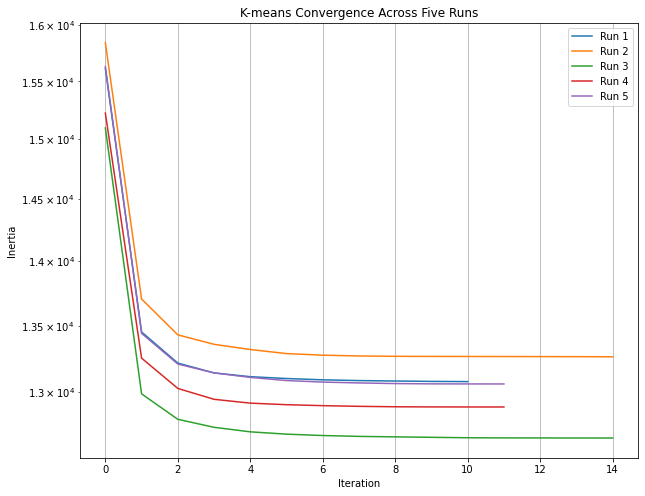

Average NMI Score over five runs: 0.2521


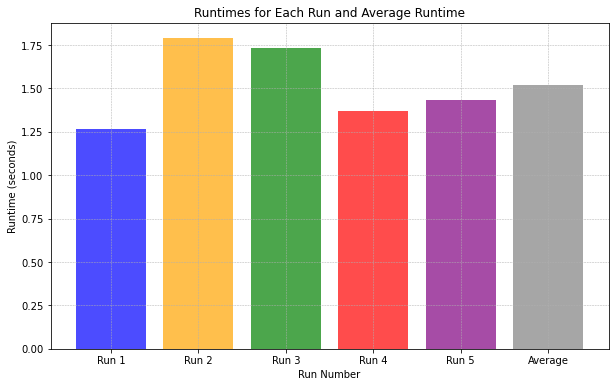

In [20]:
import numpy as np
from sklearn.metrics import normalized_mutual_info_score
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

def lightweight_coreset(X, k, m):
    n = X.shape[0]
    if n < m:
        print(f"Warning: The dataset size ({n}) is smaller than the coreset size ({m}). Consider allowing replacement or reducing the coreset size.")
        # Uncomment the next line to allow replacement if necessary
        # return X, np.ones(n) / n  # Return the entire dataset with uniform weights if m &gt; n
    # Compute the mean of the data
    mu = np.mean(X, axis=0)
    # Compute distances from the mean
    dists_sq = np.sum((X - mu) ** 2, axis=1)
    total_dist_sq = np.sum(dists_sq)
    
    # Probability distribution for importance sampling
    q = 0.5 / X.shape[0] + 0.5 * dists_sq / total_dist_sq
    # Sampling according to q
    indices = np.random.choice(X.shape[0], size=m, replace=False, p=q / q.sum())
    # Compute weights inversely proportional to q
    weights = 1 / (m * q[indices])
    
    return X[indices], weights

def initialize_centroids(X, k):
    indices = np.random.permutation(X.shape[0])[:k]
    return X[indices]

def assign_clusters(X, centroids):
    distances = np.sqrt(((X[:, np.newaxis] - centroids) ** 2).sum(axis=2))
    labels = np.argmin(distances, axis=1)
    return labels, distances.min(axis=1).sum()

def update_centroids(X, labels, k, weights):


    n_features = X.shape[1]
    centroids = np.zeros((k, n_features))
    for i in range(k):
        cluster_indices = labels == i
        if np.sum(weights[cluster_indices]) > 0:
            weighted_points = X[cluster_indices] * weights[cluster_indices, np.newaxis]
            centroids[i] = weighted_points.sum(axis=0) / weights[cluster_indices].sum()
        else:
            centroids[i] = X[np.random.choice(X.shape[0])]
    return centroids

def kmeans_coreset(X, k, coreset_size, max_iters=100):
    start_time = time.time()
    if coreset_size < k:
        raise ValueError(f"Coreset size {coreset_size} must be at least as large as k {k}.")
    
    # Step 1: Sample the lightweight coreset
    coreset, weights = lightweight_coreset(X, k, coreset_size)
    
    # Step 2: Run K-means on the coreset
    centroids = initialize_centroids(coreset, k)
    inertia_history = []
    total_distance_calculations = 0
    
    for i in tqdm(range(max_iters), desc="K-means Iteration"):
        labels, inertia = assign_clusters(coreset, centroids)
        inertia_history.append(inertia)
        new_centroids = update_centroids(coreset, labels, k, weights)
        total_distance_calculations += coreset.shape[0] * k
        if np.all(centroids == new_centroids):
            break
        centroids = new_centroids

    runtime = time.time() - start_time
    
    # Step 3: Assign clusters to all points
    full_labels = assign_clusters(X, centroids)[0]
    return centroids, full_labels, i+1, inertia_history, total_distance_calculations, runtime

# Example usage with a dummy dataset
if __name__ == "__main__":
    from sklearn.datasets import make_blobs

    k = 153
    max_iters = 50

    # Lists to store results
    all_labels = []
    all_centroids = []
    all_nmi_scores = []
    all_runtimes = []
    all_distance_calculations = []
    all_inertia_histories = []
    all_num_iterations = []

    # Perform clustering five times
    for i in range(5):
        centroids, labels, num_iterations, inertia_history, distance_calculations, runtime = kmeans_coreset(X, k, 2000, max_iters)
        nmi_score = normalized_mutual_info_score(true_labels, labels, average_method='arithmetic')

        # Append results to lists
        all_num_iterations.append(num_iterations)
        all_labels.append(labels)
        all_centroids.append(centroids)
        all_nmi_scores.append(nmi_score)
        all_runtimes.append(runtime)
        all_distance_calculations.append(distance_calculations)
        all_inertia_histories.append(inertia_history)

    plt.figure(figsize=(10, 8))
    for i, inertia_history in enumerate(all_inertia_histories):
        plt.plot(inertia_history, label=f'Run {i+1}')
    plt.title('K-means Convergence Across Five Runs')
    plt.xlabel('Iteration')
    plt.ylabel('Inertia')
    plt.yscale('log')  # Set the y-axis to a logarithmic scale
    plt.legend()
    plt.grid(True)
    plt.show()

    average_nmi = np.mean(all_nmi_scores)
    print(f"Average NMI Score over five runs: {average_nmi:.4f}")

    # Assuming `all_runtimes` contains the runtime for each of the five runs
    average_runtime = np.mean(all_runtimes)
    # Define a list of colors for the bars
    colors = ['blue', 'orange', 'green','red',   'purple']

    plt.figure(figsize=(10, 6))
    bar_colors = colors + ['grey']  # Add grey color for the average bar
    plt.bar(range(1, 7), all_runtimes + [average_runtime], color=bar_colors, alpha=0.7)
    plt.xlabel('Run Number')
    plt.ylabel('Runtime (seconds)')
    plt.title('Runtimes for Each Run and Average Runtime')
    plt.xticks(range(1, 7), labels=[f'Run {i}' for i in range(1, 6)] + ['Average'])
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()
